In [13]:
import os
import kagglehub

# Download dataset
path = kagglehub.dataset_download("omkarmanohardalvi/lungs-disease-dataset-4-types")
print("Dataset path:", path)

Dataset path: /kaggle/input/lungs-disease-dataset-4-types


In [14]:
!pip install -q imutils

import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [15]:
# Set parameters
image_size = 300
batch_size = 32
num_classes = 5
categories = ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']

In [16]:
# Dataset path
base_dir = "/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset/train"


In [17]:
# Image Cropping Function
def crop_center(img):
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_x = w // 2 - min_dim // 2
    start_y = h // 2 - min_dim // 2
    return img[start_y:start_y+min_dim, start_x:start_x+min_dim]

In [18]:
# Load and preprocess images
data, labels = [], []
sample_images = []
sample_cropped = []

for label, category in enumerate(categories):
    folder_path = os.path.join(base_dir, category)
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    for i, img_path in enumerate(tqdm(image_paths, desc=f"Processing {category}")):
        img = cv2.imread(img_path)
        if img is None:
            continue
        if i == 0:
            sample_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img = crop_center(img)
        if i == 0:
            sample_cropped.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img = cv2.resize(img, (image_size, image_size))
        img = preprocess_input(img)
        data.append(img)
        labels.append(label)

Processing Viral Pneumonia: 100%|██████████| 1204/1204 [00:06<00:00, 198.61it/s]


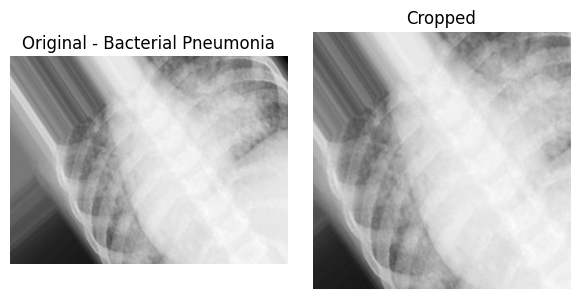

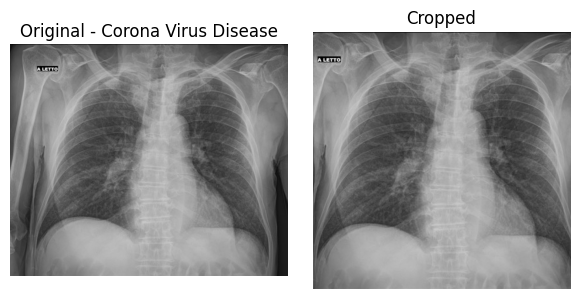

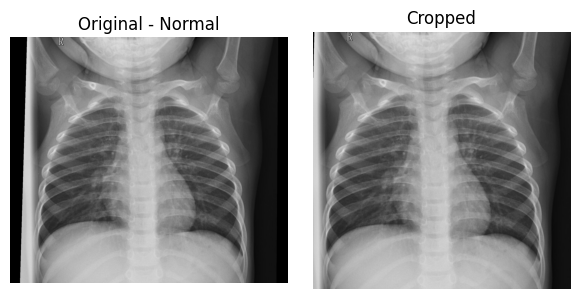

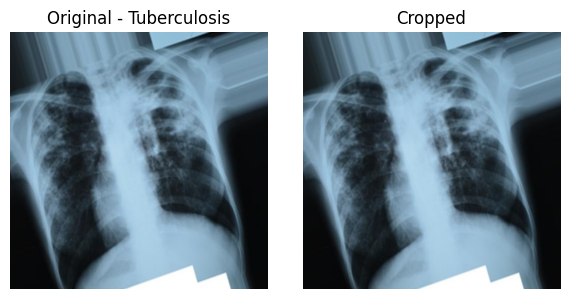

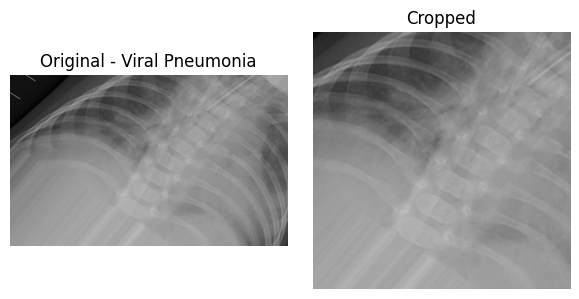

In [19]:
# Show original vs cropped samples
for i in range(len(sample_images)):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_images[i])
    plt.title(f"Original - {categories[i]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sample_cropped[i])
    plt.title("Cropped")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
x_data = np.array(data)
y_data = to_categorical(labels, num_classes=num_classes)


In [20]:
# Split dataset
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)


In [21]:
# Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_data, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

In [22]:
# TensorFlow Datasets with augmentation
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    return img, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [23]:
# Build Model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in base_model.layers[:200]:
    layer.trainable = False
for layer in base_model.layers[200:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,178,292 (42.64 MB)

 Trainable params: 10,216,595 (38.97 MB)

 Non-trainable params: 961,697 (3.67 MB)

In [27]:
# Callbacks
callbacks = [

    ModelCheckpoint('best_model_b3.h5', save_best_only=True)
]


In [28]:
# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9678 - loss: 0.1328

152/152 ━━━━━━━━━━━━━━━━━━━━ 45s 279ms/step - accuracy: 0.9678 - loss: 0.1328 - val_accuracy: 0.9298 - val_loss: 0.2837
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9785 - loss: 0.1063

152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 286ms/step - accuracy: 0.9784 - loss: 0.1063 - val_accuracy: 0.9298 - val_loss: 0.2824
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 285ms/step - accuracy: 0.9839 - loss: 0.0932 - val_accuracy: 0.9298 - val_loss: 0.3810
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 43s 278ms/step - accuracy: 0.9851 - loss: 0.0859 - val_accuracy: 0.9306 - val_loss: 0.3355
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.9839 - loss: 0.0864 - val_accuracy: 0.9199 - val_loss: 0.4361
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 284ms/step - accuracy: 0.9884 - loss: 0.0794 - val_accuracy: 0.9364 - val_loss: 0.3079
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.9912 - loss: 0.0721 - val_accuracy: 0.9348 - val_loss: 0.3147
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 286ms/step - accuracy: 0.9892 - loss: 0.0739 - val_accuracy: 0.9232 - val_loss: 0.3367
Epoch 9/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 43s 279ms/step - accuracy: 0.9902 - loss: 0.0727 - val

In [29]:
# Evaluate
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step


In [30]:
# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=categories))

                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.90      0.80      0.84       241
Corona Virus Disease       1.00      1.00      1.00       244
              Normal       0.97      0.97      0.97       241
        Tuberculosis       1.00      1.00      1.00       244
     Viral Pneumonia       0.80      0.90      0.85       241

            accuracy                           0.93      1211
           macro avg       0.93      0.93      0.93      1211
        weighted avg       0.93      0.93      0.93      1211



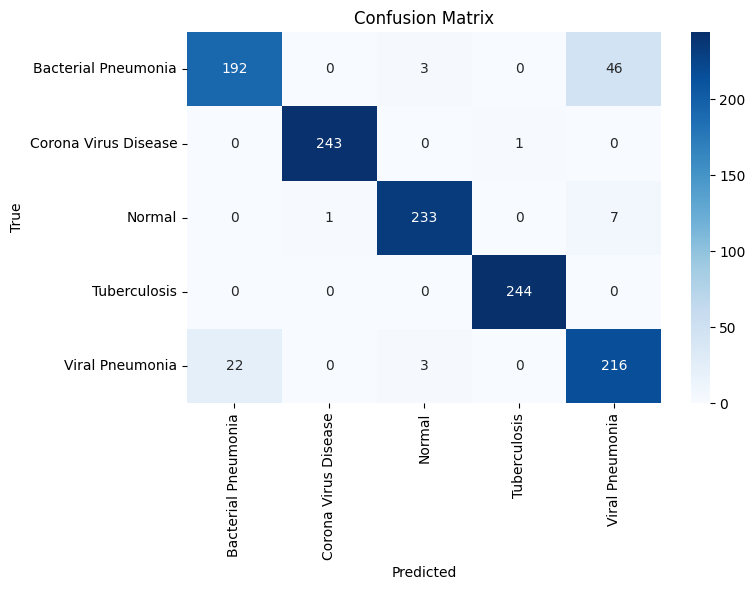

In [31]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

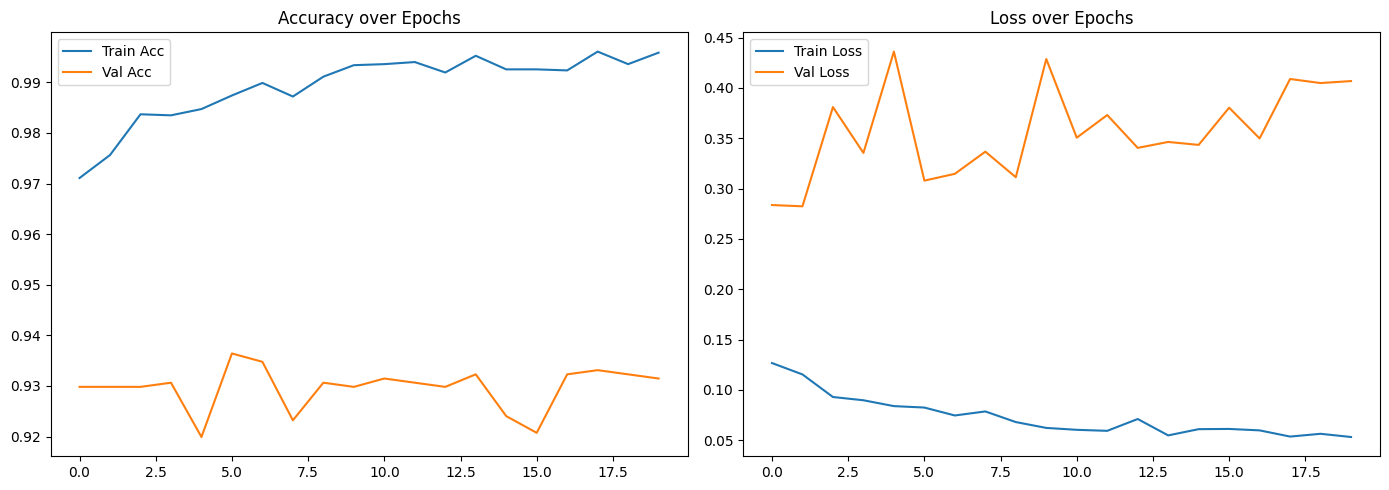

In [32]:
# Accuracy and Loss Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.tight_layout()
plt.show()

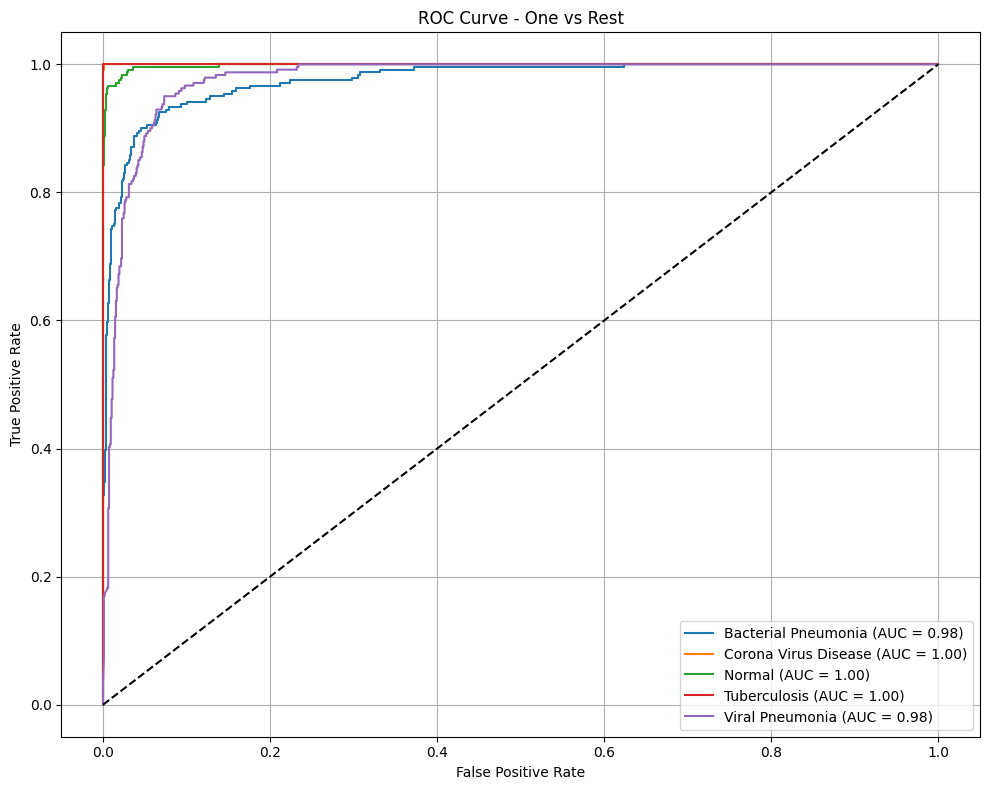

In [33]:
# ROC Curve for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{categories[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - One vs Rest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()